# Importing Data

In [1]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset")

Skipping, found downloaded files in "./brain-tumor-mri-dataset" (use force=True to force download)


In [1]:
import os
import pandas as pd

image_path = []
image_label = []

for i in os.listdir("brain-tumor-mri-dataset"):
    for label in os.listdir(f"brain-tumor-mri-dataset/{i}"):
        for image in os.listdir(f"brain-tumor-mri-dataset/{i}/{label}"):
            image_path.append(f"brain-tumor-mri-dataset/{i}/{label}/{image}")
            image_label.append(label)

data_df = pd.DataFrame(zip(image_path, image_label), columns=["image_path", "label"])
data_df.head()

,image_path,label
0,brain-tumor-mri-dataset/Testing/glioma/Te-glTr...,glioma
1,brain-tumor-mri-dataset/Testing/glioma/Te-glTr...,glioma
2,brain-tumor-mri-dataset/Testing/glioma/Te-glTr...,glioma
3,brain-tumor-mri-dataset/Testing/glioma/Te-glTr...,glioma
4,brain-tumor-mri-dataset/Testing/glioma/Te-glTr...,glioma


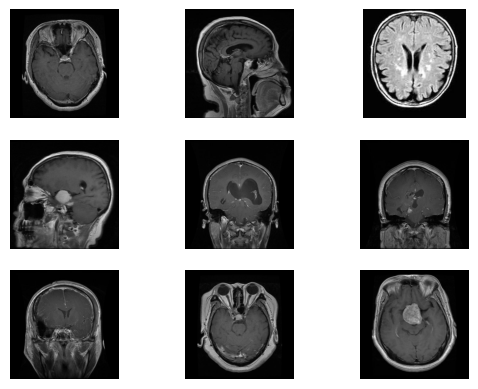

In [2]:
import matplotlib.pyplot as plt
from PIL import Image

n_rows = 3
n_cols = 3

f, axarr = plt.subplots(n_rows, n_cols)

for row in range(n_rows):
    for col in range(n_cols):
        image = Image.open(data_df.sample(n=1)["image_path"].iloc[0]).convert("RGB")
        axarr[row, col].imshow(image)
        axarr[row, col].axis("off")

plt.show()

# Preparing Data

In [3]:
train = data_df.sample(frac=0.7)
test = data_df.drop(train.index)

val = test.sample(frac=0.5)
test = test.drop(val.index)

In [4]:
import torch
from sklearn.preprocessing import LabelEncoder
from torchvision.transforms import transforms

label_encoder = LabelEncoder()
label_encoder.fit(data_df["label"])

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    transforms.ConvertImageDtype(torch.float)
])

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2,
                           contrast=0.2,
                           saturation=0.2,
                           hue=0.1),
    transforms.RandomAffine(degrees=0,
                            translate=(0.1, 0.1)),
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
    transforms.ConvertImageDtype(torch.float)
])

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [6]:
from torch.utils.data import Dataset, DataLoader

class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.labels = torch.tensor(label_encoder.transform(dataframe['label'])).to(device)

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        label = self.labels[idx]
    
        image = Image.open(img_path).convert('RGB')
    
        if self.transform:
          image = self.transform(image).to(device)
    
        return image, label

In [7]:
normal_train_dataset = CustomImageDataset(dataframe = train, transform=transform)
aug_train_dataset = CustomImageDataset(dataframe=train, transform=train_transform)
train_dataset = torch.utils.data.ConcatDataset([normal_train_dataset, aug_train_dataset])

val_dataset = CustomImageDataset(dataframe = val, transform=transform)
test_dataset = CustomImageDataset(dataframe = test, transform=transform)

# Creating the Model

## Importing ResNet-50

In [8]:
import torchvision.models as models
from torch import nn

num_classes = len(data_df['label'].unique())

model = models.resnet50(weights="IMAGENET1K_V2")
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [9]:
from torchsummary import summary
summary(model, input_size=(3,224,224))

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            9,408
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
|    └─Bottleneck: 2-1                   --
|    |    └─Conv2d: 3-1                  4,096
|    |    └─BatchNorm2d: 3-2             128
|    |    └─Conv2d: 3-3                  36,864
|    |    └─BatchNorm2d: 3-4             128
|    |    └─Conv2d: 3-5                  16,384
|    |    └─BatchNorm2d: 3-6             512
|    |    └─ReLU: 3-7                    --
|    |    └─Sequential: 3-8              16,896
|    └─Bottleneck: 2-2                   --
|    |    └─Conv2d: 3-9                  16,384
|    |    └─BatchNorm2d: 3-10            128
|    |    └─Conv2d: 3-11                 36,864
|    |    └─BatchNorm2d: 3-12            128
|    |    └─Conv2d: 3-13                 16,384
|    |    └─BatchNorm2d: 3-14      

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            9,408
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
|    └─Bottleneck: 2-1                   --
|    |    └─Conv2d: 3-1                  4,096
|    |    └─BatchNorm2d: 3-2             128
|    |    └─Conv2d: 3-3                  36,864
|    |    └─BatchNorm2d: 3-4             128
|    |    └─Conv2d: 3-5                  16,384
|    |    └─BatchNorm2d: 3-6             512
|    |    └─ReLU: 3-7                    --
|    |    └─Sequential: 3-8              16,896
|    └─Bottleneck: 2-2                   --
|    |    └─Conv2d: 3-9                  16,384
|    |    └─BatchNorm2d: 3-10            128
|    |    └─Conv2d: 3-11                 36,864
|    |    └─BatchNorm2d: 3-12            128
|    |    └─Conv2d: 3-13                 16,384
|    |    └─BatchNorm2d: 3-14      

## (Loading already trained Model)

In [ ]:
def load_model(model, path='resNet50_tumorDetection_model.pth'):
    model.load_state_dict(torch.load(path))

load_model(model)

# Training the Model

In [ ]:
LR = 1e-3
MOMENTUM = 0.9
WEIGHT_DECAY = 1e-4
BATCH_SIZE = 32
STEP_SIZE = 10
GAMMA = 0.5
EPOCHS = 50

In [11]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [12]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

In [ ]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

for epoch in range(EPOCHS):
    total_acc_train = 0
    total_loss_train = 0
    total_loss_val = 0
    total_acc_val = 0
    
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        train_loss = criterion(outputs, labels)
        total_loss_train += train_loss.item()

        train_loss.backward()

        train_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
        total_acc_train += train_acc

        optimizer.step()

    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
          outputs = model(inputs)
          val_loss = criterion(outputs, labels)
          total_loss_val += val_loss.item()
    
          val_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
          total_acc_val += val_acc

    total_loss_train_plot.append(round(total_loss_train/1000, 4))
    total_loss_validation_plot.append(round(total_loss_val/1000, 4))
    
    total_acc_train_plot.append(round((total_acc_train/train_dataset.__len__())*100,4))
    total_acc_validation_plot.append(round((total_acc_val/val_dataset.__len__())*100, 4))

    print(f'''Epoch {epoch+1}/{EPOCHS}:
  Train Loss: {round(total_loss_train/1000, 4)}
  Train Accuracy: {round((total_acc_train/train_dataset.__len__())*100,4)}%
  Validation Loss: {round(total_loss_val/1000, 4)}
  Validation Accuracy: {round((total_acc_val/val_dataset.__len__())*100, 4)}%
  ''')
    scheduler.step()

Epoch 1/50:
  Train Loss: 0.2203
  Train Accuracy: 73.5456%
  Validation Loss: 0.0082
  Validation Accuracy: 91.0816%
  
Epoch 2/50:
  Train Loss: 0.093
  Train Accuracy: 88.5679%
  Validation Loss: 0.0043
  Validation Accuracy: 94.9715%
  
Epoch 3/50:
  Train Loss: 0.0665
  Train Accuracy: 92.1989%
  Validation Loss: 0.0027
  Validation Accuracy: 97.3435%
  
Epoch 4/50:
  Train Loss: 0.0536
  Train Accuracy: 93.8466%
  Validation Loss: 0.0022
  Validation Accuracy: 97.6281%
  
Epoch 5/50:
  Train Loss: 0.0467
  Train Accuracy: 94.5382%
  Validation Loss: 0.0023
  Validation Accuracy: 97.5332%
  
Epoch 6/50:
  Train Loss: 0.0396
  Train Accuracy: 95.7079%
  Validation Loss: 0.0031
  Validation Accuracy: 96.3947%
  
Epoch 7/50:
  Train Loss: 0.0385
  Train Accuracy: 95.4434%
  Validation Loss: 0.0017
  Validation Accuracy: 97.723%
  
Epoch 8/50:
  Train Loss: 0.0337
  Train Accuracy: 96.1351%
  Validation Loss: 0.0014
  Validation Accuracy: 98.6717%
  
Epoch 9/50:
  Train Loss: 0.0314
 

# Evaluating the Model

In [ ]:
model.eval()
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for inputs, labels in test_loader:
    predictions = model(inputs)

    acc = (torch.argmax(predictions, axis = 1) == labels).sum().item()
    total_acc_test += acc
    test_loss = criterion(predictions, labels)
    total_loss_test += test_loss.item()

print(f"Accuracy Score is: {round((total_acc_test/test_dataset.__len__())*100, 4)}% and Loss is {round(total_loss_test/1000,4)}")

In [ ]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation ACcuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.show()

# Saving the Model

In [ ]:
def save_model(model, path='resNet50_tumorDetection_model.pth'):
    torch.save(model.state_dict(), path)

save_model(model)

In [ ]:
import json

my_dict = {
    "total_loss_train_plot": total_loss_train_plot,
    "total_loss_validation_plot": total_loss_validation_plot,
    "total_acc_train_plot": total_acc_train_plot,
    "total_acc_validation_plot": total_acc_validation_plot
}

with open("loss_acc.json", "w") as file:
    json.dump(my_dict, file, indent=4)